<a href="https://colab.research.google.com/github/malakamgad24/Neural-Networks/blob/main/Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Section 1: Importing the dataset**



In [ ]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

path = kagglehub.dataset_download("mkechinov/ecommerce-events-history-in-electronics-store")
df = pd.read_csv(path + '/events.csv')

df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2020-09-24 11:57:06 UTC,view,1996170,2144415922528452715,electronics.telephone,NaN,31.90,1515915625519388267,LJuJVLEjPT
1,2020-09-24 11:57:26 UTC,view,139905,2144415926932472027,computers.components.cooler,zalman,17.16,1515915625519380411,tdicluNnRY
2,2020-09-24 11:57:27 UTC,view,215454,2144415927158964449,NaN,NaN,9.81,1515915625513238515,4TMArHtXQy
3,2020-09-24 11:57:33 UTC,view,635807,2144415923107266682,computers.peripherals.printer,pantum,113.81,1515915625519014356,aGFYrNgC08
4,2020-09-24 11:57:36 UTC,view,3658723,2144415921169498184,NaN,cameronsino,15.87,1515915625510743344,aa4mmk0kwQ


# **Data Pre-processing**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 885129 entries, 0 to 885128
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   event_time     885129 non-null  object 
 1   event_type     885129 non-null  object 
 2   product_id     885129 non-null  int64  
 3   category_id    885129 non-null  int64  
 4   category_code  648910 non-null  object 
 5   brand          672765 non-null  object 
 6   price          885129 non-null  float64
 7   user_id        885129 non-null  int64  
 8   user_session   884964 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 60.8+ MB


Count rows with any NaN value

In [ ]:
null_values = df.isnull().sum()

print("Column Names and Null Values:")
for column, null_count in null_values.items():
    print(f"{column}: {null_count} null values")


Column Names and Null Values:
event_time: 0 null values
event_type: 0 null values
product_id: 0 null values
category_id: 0 null values
category_code: 236219 null values
brand: 212364 null values
price: 0 null values
user_id: 0 null values
user_session: 165 null values


Handling Missing Values

In [ ]:
df['category_code'].fillna('unknown', inplace=True)
df['brand'].fillna('unknown', inplace=True)

df.dropna(subset=['user_session'], inplace=True)

null_values_after = df.isnull().sum()
print("Null Values After Handling:")
print(null_values_after)


<ipython-input-39-959dce27eb6f>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['category_code'].fillna('unknown', inplace=True)
<ipython-input-39-959dce27eb6f>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try u

Null Values After Handling:
event_time       0
event_type       0
product_id       0
category_id      0
category_code    0
brand            0
price            0
user_id          0
user_session     0
dtype: int64


checking for duplicates

In [ ]:
duplicates = df[df.duplicated()]
print(f"Number of duplicate rows: {duplicates.shape[0]}")

if not duplicates.empty:
    print("Duplicate rows:")
    print(duplicates)
else:
    print("No duplicate rows found.")


Number of duplicate rows: 652
Duplicate rows:
                     event_time event_type  product_id          category_id  \
512     2020-09-24 13:51:07 UTC       view      387956  2144415922427789416   
975     2020-09-24 15:48:55 UTC       view      874667  2144415922738167921   
4828    2020-09-25 13:15:09 UTC       view      453469  2144415924222951574   
6144    2020-09-25 19:31:42 UTC       view     1010933  2144415921932861531   
8706    2020-09-26 15:32:01 UTC       view     1248094  2144415966652530999   
...                         ...        ...         ...                  ...   
876900  2021-02-27 11:17:09 UTC       view      525416  2144415940119364164   
877116  2021-02-27 12:02:26 UTC       view     3804563  2144415926966026460   
878751  2021-02-27 17:56:05 UTC       view     1571204  2144415924491387038   
879545  2021-02-27 20:54:20 UTC       view     1027953  2144415923837075596   
882716  2021-02-28 14:18:02 UTC       view     4078916  2144415922427789416   

     

dropping duplicates

In [ ]:
df.drop_duplicates(inplace=True)

are_duplicates_remaining = df.duplicated().any()

if are_duplicates_remaining:
    print("There are still duplicate rows in the DataFrame.")
else:
    print("No duplicate rows remain in the DataFrame.")

No duplicate rows remain in the DataFrame.


Convert and Sort event_time

In [ ]:
df['event_time'] = pd.to_datetime(df['event_time'])
df.sort_values(by=['user_id', 'event_time'], inplace=True)

# **Section 2: Chosen Attributes Analysis**

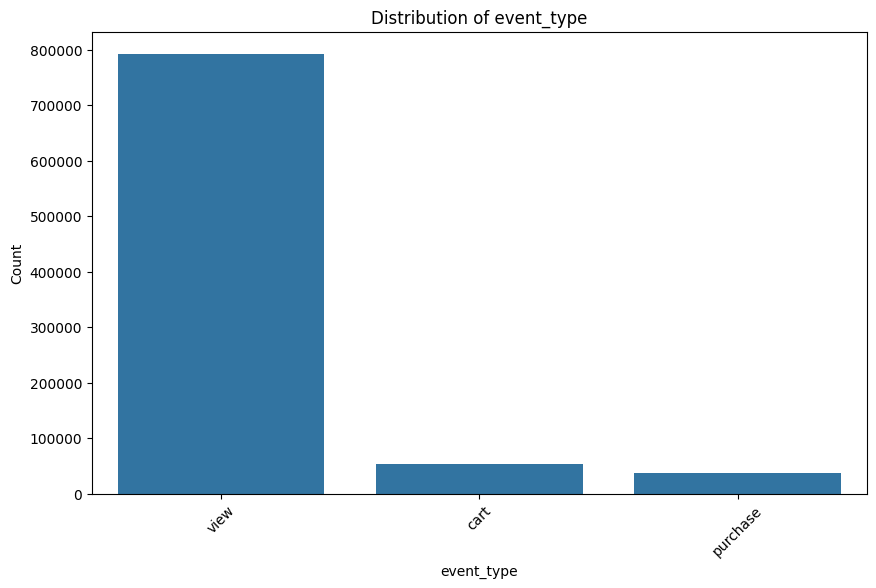

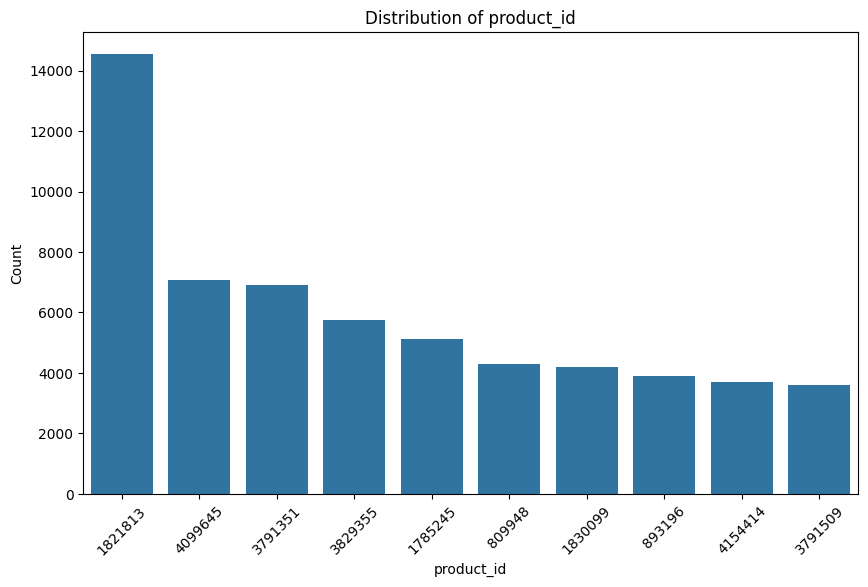

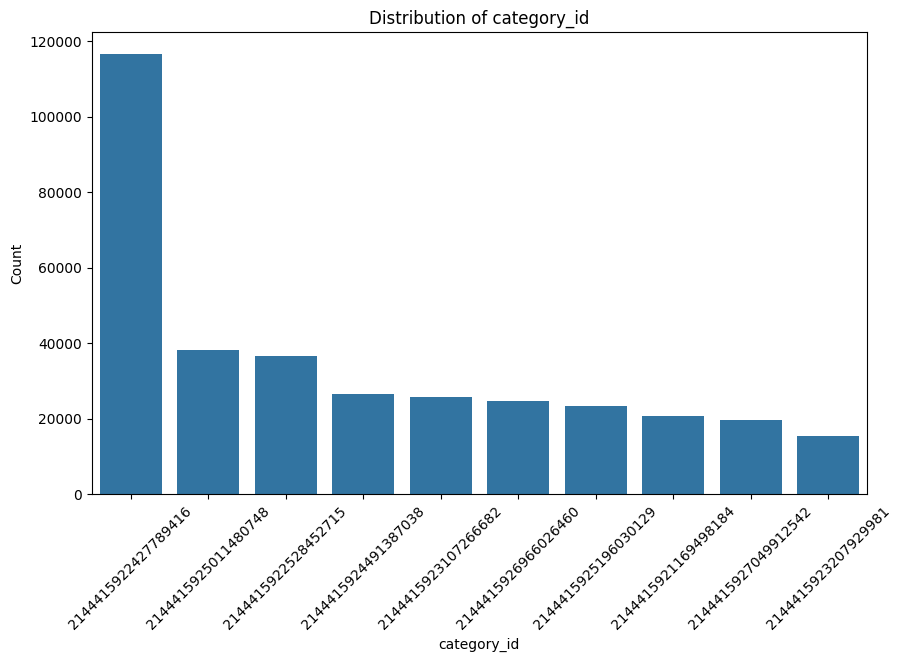

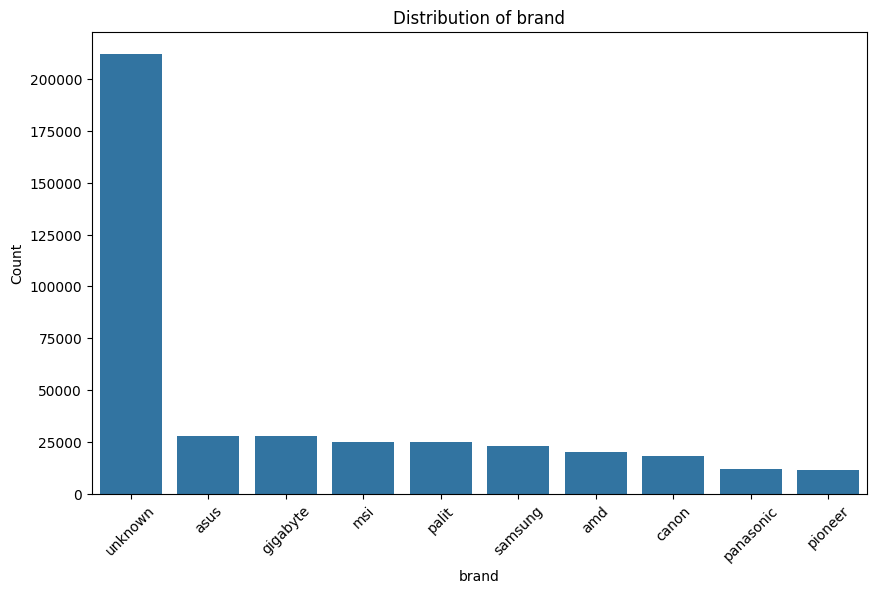

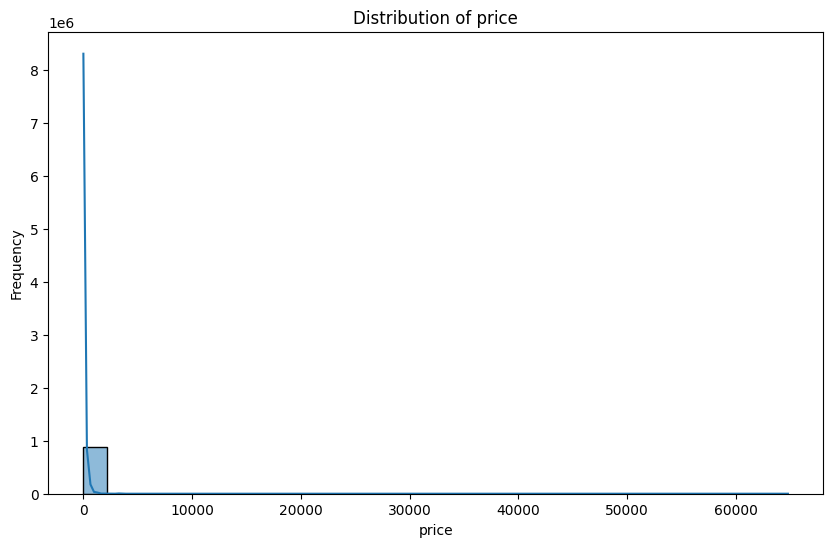

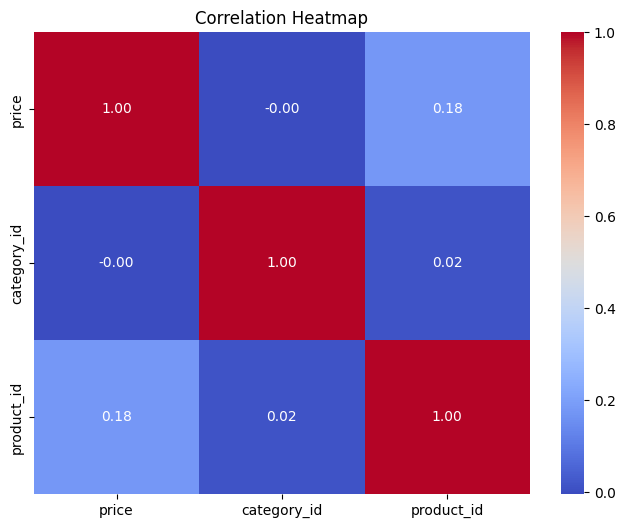

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# plot categorical attribute distributions
def plot_categorical_distribution(column_name):
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x=column_name, order=df[column_name].value_counts().index[:10])
    plt.title(f"Distribution of {column_name}")
    plt.xlabel(column_name)
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()

# plot numerical attribute distribution
def plot_numerical_distribution(column_name):
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x=column_name, kde=True, bins=30)
    plt.title(f"Distribution of {column_name}")
    plt.xlabel(column_name)
    plt.ylabel("Frequency")
    plt.show()

# Analyze 'event_type'
plot_categorical_distribution('event_type')

# Analyze 'product_id'
plot_categorical_distribution('product_id')

# Analyze 'category_id'
plot_categorical_distribution('category_id')

# Analyze 'brand'
plot_categorical_distribution('brand')

# Analyze 'price'
plot_numerical_distribution('price')

# Correlation heatmap for numerical features
plt.figure(figsize=(8, 6))
correlation_matrix = df[['price', 'category_id', 'product_id']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()



# **Section 3: Analysis of the attribute chosen as the output to be predicted (event_type)**

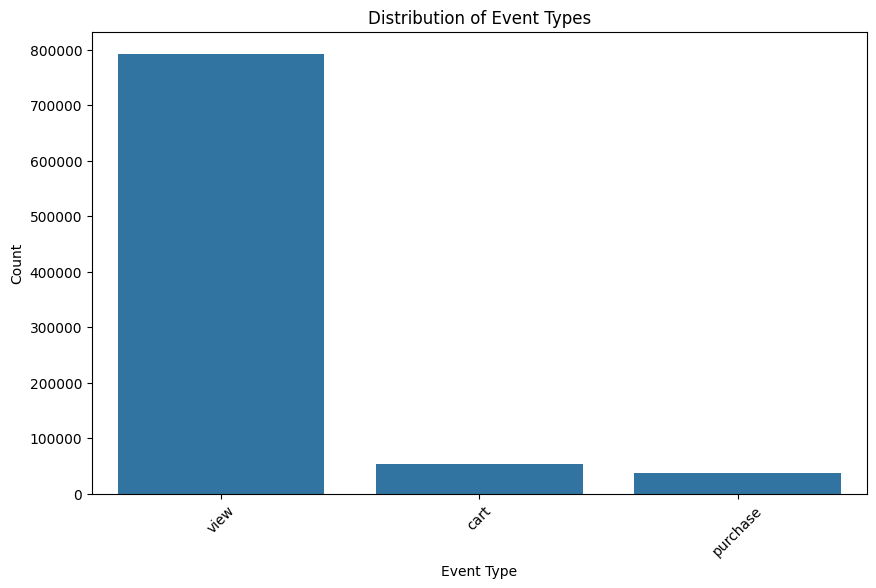

Percentage Distribution of Event Types:
event_type
view        89.667787
cart         6.109382
purchase     4.222831
Name: proportion, dtype: float64


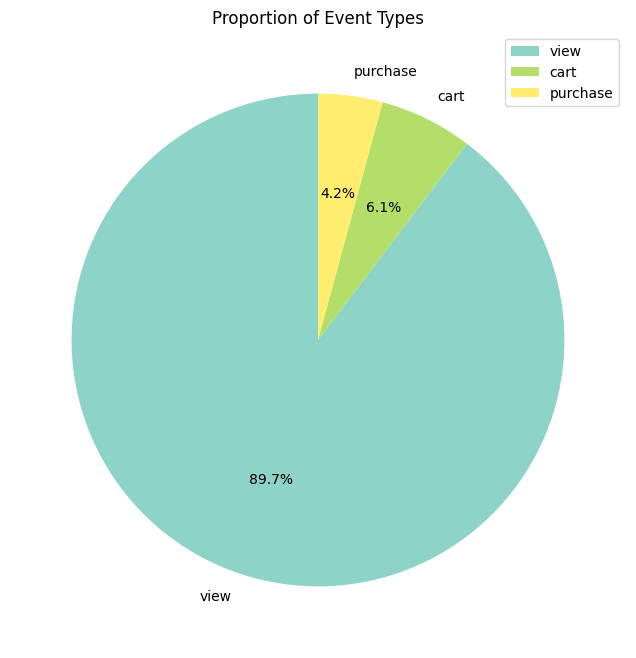

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='event_type', order=df['event_type'].value_counts().index)
plt.title("Distribution of Event Types")
plt.xlabel("Event Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

# Calculate percentages for each event type
event_type_distribution = df['event_type'].value_counts(normalize=True) * 100

print("Percentage Distribution of Event Types:")
print(event_type_distribution)

# Pie chart
plt.figure(figsize=(8, 8))
df['event_type'].value_counts().plot.pie(
    autopct='%1.1f%%', startangle=90, cmap="Set3", legend=True
)
plt.title("Proportion of Event Types")
plt.ylabel("")  # Hide y-label
plt.show()


# Encoding

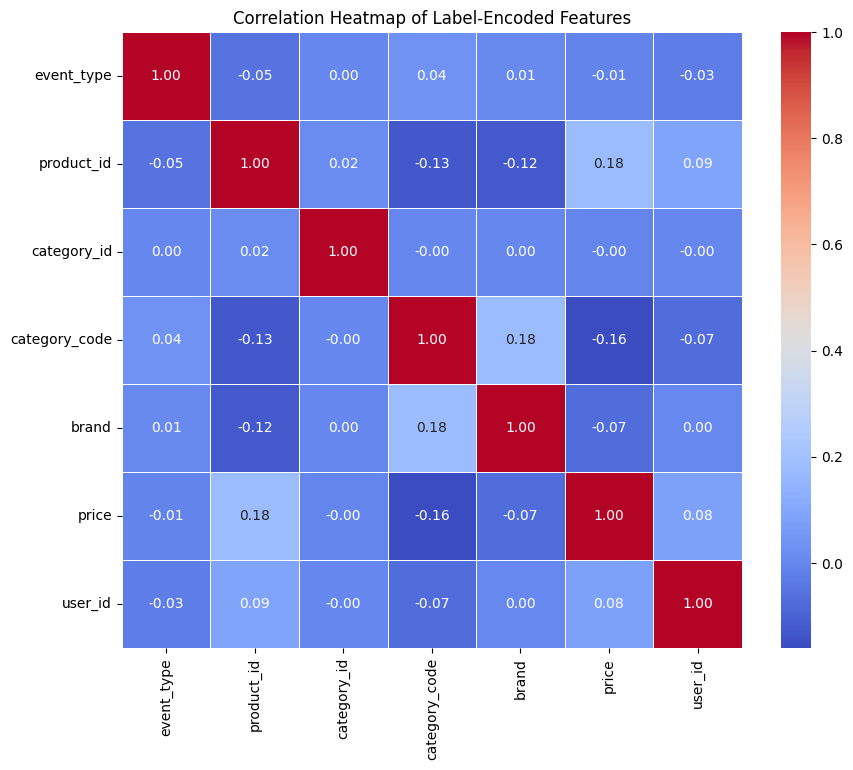

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Label Encoding for categorical columns
label_encoders = {}
for col in ['event_type', 'category_code', 'brand']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])  # Transform and encode the column
    label_encoders[col] = le  # Store the encoder for possible inverse transformation

# Ensure only numeric columns are in the correlation calculation
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = df[numeric_columns].corr()


# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Heatmap of Label-Encoded Features")
plt.show()

In [ ]:
df.drop(columns=['category_id'], inplace=True)

we dropped category_id because it has no correlation with event_type

# Normalize price

In [ ]:
scaler = MinMaxScaler()
df['price'] = scaler.fit_transform(df[['price']])

# Generate Sequences

In [ ]:
sequence_length = 10

features = ['event_type', 'product_id', 'brand', 'price']

# Ensure the data is sorted by user and time for sequential data
df.sort_values(by=['user_id', 'event_time'], inplace=True)

grouped = df.groupby(['user_id', 'user_session'])

sequences = []
labels = []

for _, group in grouped:
    group_values = group[features].values
    for i in range(len(group_values) - sequence_length):
        sequences.append(group_values[i:i + sequence_length])
        # Label is the next `event_type`
        labels.append(group_values[i + sequence_length, 0])

sequences = np.array(sequences)
labels = np.array(labels)

print(f"Sequences shape: {sequences.shape}")  # Should be (num_sequences, sequence_length, num_features)
print(f"Labels shape: {labels.shape}")        # Should be (num_sequences,)


Sequences shape: (52280, 10, 4)
Labels shape: (52280,)


# Train Test split

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

X_train, X_test, y_train, y_test = train_test_split(
    sequences, labels, test_size=0.2, random_state=42, stratify=labels
)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print(f"Training data shape: {X_train.shape}, Training labels shape: {y_train.shape}")
print(f"Testing data shape: {X_test.shape}, Testing labels shape: {y_test.shape}")


Training data shape: (41824, 10, 4), Training labels shape: (41824, 3)
Testing data shape: (10456, 10, 4), Testing labels shape: (10456, 3)


# **Section 4: Construction of LSTM Neural Network Model**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
    Dense(y_train.shape[1], activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=128,
    verbose=2,
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 128)                 │          68,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 68,483 (267.51 KB)

 Trainable params: 68,483 (267.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
262/262 - 3s - 10ms/step - accuracy: 0.8033 - loss: 0.6375 - val_accuracy: 0.8068 - val_loss: 0.6247
Epoch 2/20
262/262 - 2s - 7ms/step - accuracy: 0.8062 - loss: 0.6272 - val_accuracy: 0.8068 - val_loss: 0.6286
Epoch 3/20
262/262 - 1s - 4ms/step - accuracy: 0.8062 - loss: 0.6267 - val_accuracy: 0.8068 - val_loss: 0.6256
Epoch 4/20
262/262 - 1s - 5ms/step - accuracy: 0.8062 - loss: 0.6265 - val_accuracy: 0.8068 - val_loss: 0.6263
Epoch 5/20
262/262 - 1s - 5ms/step - accuracy: 0.8062 - loss: 0.6265 - val_accuracy: 0.8068 - val_loss: 0.6263
Epoch 6/20
262/262 - 1s - 4ms/step - accuracy: 0.8062 - loss: 0.6265 - val_accuracy: 0.8068 - val_loss: 0.6260
Epoch 7/20
262/262 - 1s - 5ms/step - accuracy: 0.8062 - loss: 0.6269 - val_accuracy: 0.8068 - val_loss: 0.6247
Epoch 8/20
262/262 - 1s - 5ms/step - accuracy: 0.8062 - loss: 0.6262 - val_accuracy: 0.8068 - val_loss: 0.6264
Epoch 9/20
262/262 - 1s - 4ms/step - accuracy: 0.8062 - loss: 0.6269 - val_accuracy: 0.8068 - val_loss: 0.6254


# **Evaluate the Model**

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


327/327 - 1s - 2ms/step - accuracy: 0.8063 - loss: 0.6264
Test Loss: 0.6263713240623474, Test Accuracy: 0.8063312768936157


# **Visualizing Training History**

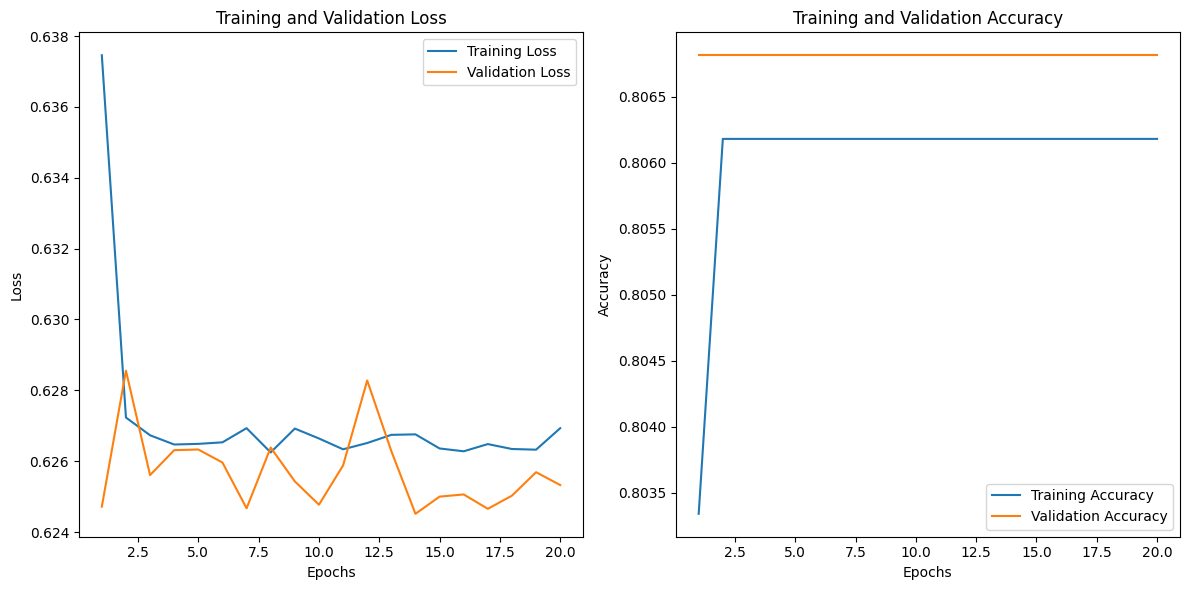

In [ ]:
import matplotlib.pyplot as plt

history_dict = history.history
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# **Section 5: Model Predictions and Probabilities**

In [ ]:
y_pred_probabilities = model.predict(X_test, verbose=2)

y_pred_classes = np.argmax(y_pred_probabilities, axis=1)

print("Predicted Probabilities (first 10 samples):")
for i in range(10):
    print(f"Sample {i+1}:")
    print(f"Predicted Probabilities: {y_pred_probabilities[i]}")
    print(f"Predicted Class: {y_pred_classes[i]}")
    print()

true_labels = np.argmax(y_test, axis=1)
print("True vs Predicted Labels (first 10 samples):")
for i in range(10):
    print(f"Sample {i+1}: True Label: {true_labels[i]}, Predicted Label: {y_pred_classes[i]}")

accuracy = np.mean(y_pred_classes == true_labels)
print(f"\nModel Accuracy on Test Set: {accuracy:.4f}")


327/327 - 1s - 2ms/step
Predicted Probabilities (first 10 samples):
Sample 1:
Predicted Probabilities: [0.09053031 0.08796664 0.8215031 ]
Predicted Class: 2

Sample 2:
Predicted Probabilities: [0.09053031 0.08796664 0.8215031 ]
Predicted Class: 2

Sample 3:
Predicted Probabilities: [0.09053031 0.08796664 0.8215031 ]
Predicted Class: 2

Sample 4:
Predicted Probabilities: [0.09053031 0.08796664 0.8215031 ]
Predicted Class: 2

Sample 5:
Predicted Probabilities: [0.09053031 0.08796664 0.8215031 ]
Predicted Class: 2

Sample 6:
Predicted Probabilities: [0.09053031 0.08796664 0.8215031 ]
Predicted Class: 2

Sample 7:
Predicted Probabilities: [0.09053031 0.08796664 0.8215031 ]
Predicted Class: 2

Sample 8:
Predicted Probabilities: [0.09053031 0.08796664 0.8215031 ]
Predicted Class: 2

Sample 9:
Predicted Probabilities: [0.09053031 0.08796664 0.8215031 ]
Predicted Class: 2

Sample 10:
Predicted Probabilities: [0.09053031 0.08796664 0.8215031 ]
Predicted Class: 2

True vs Predicted Labels (first